# Question - 1
## Implement your own neural network

In [106]:
import numpy as np
import pandas as pd
import math
import random
import pickle
import matplotlib.pyplot as plt

### Forward Propagation

Given an input layer and series of hidden layer (zero or more) and an output layer of an artifical neural network we can feed this network an image in the input layer. This further, with weights and biases of each connection between any two layers, is trained at every neuron in the next layer, with every neuron learning a specfic part of the image. Finally the ouput layer which on the basic understanding consists of neurons equivalent of all possible labels. The neuron that activates the most is our desired label.

<b>Steps:</b>
1. $z = w^Tx+b$ (w is the weight vector and b is the bias vector)
2. $a$ = $F(z)$ (where F is a funtion of z which Sigmoid,ReLu or tanh etc. to give a good distribution of real numbers)
3. Repeat steps 1 and 2 till the output layer.


### Back Propagation

After Forward Propagation, we have a label that is predocted. That predicted may not be right as out network is yet to learn the precise weights and biases that predicts the correct label most of the time. Thus Backpropagation comes to picture where we find the difference between the true labels and out predicted labels. We then propagate these changes through each layer backwards. This is important as each layer's activaions is dependent on it's previous layers. This is continued for every image in our input. After one iteration over the images we have a set of errors at every layer.

<b>Steps:</b>
1. Finding delta in the output layer: $\delta_L$ = $\dfrac{\partial C}{\partial a} * activation'(z)$
2. Finding delta in hidden layers: $\delta_L$ = $w^T_{L+1} * \nabla\delta_{L+1} * activation'(z)$
3. Finding $\nabla w_L$: $\nabla w$ = $a_{L-1} * \delta_L$
4. Finding $\nabla b_L$: $\nabla b_L = \delta_L$

### Gradient Descent

We now make use of the errors colleceted at every layer aand use gradient descent i.e change weights and bias at every layer so as to correct the weights and biases as much as possible.

The steps Forward Propagation and BackPropagation is done for every image in one iteration. Gradient descent is applied after every iteration of images. This is conitueed till we get errors approximating to zero.

The above method can be slow as datasets can be huge in size. The bove process is called <b>Stochastic Gradient Descent</b>. One way to go around this problem is use <b>Mini-batch gradient descent</b> where we apply the gradient descent after a set of images have been fed to the network. This may result in slow convergence but doesn't affect the overall accuracy much.

<b>Steps:</b>
1. $w = w - \alpha\nabla w$
2. $b = b - \alpha\nabla b$

### Activation Functions:
1. <b>Sigmoid(z): </b>$\dfrac{1}{1+\exp^{-z}}$<br><br>
2. <b>Tanh(z): </b>$\dfrac{2}{1+\exp^{-2z}}-1$<br><br>
3. <b>ReLU(z): </b><br>$z<=0, f(z) = 0$<br><br>$z>0, f(z)=z$<br><br>
where $z = w^Tx+b$ (w is the weight vector and b is the bias vector) 

### Activation Function derivatives
1. <b>Sigmoid'(z): </b>$Sigmoid(z) * (1-Sigmoid(z))$<br><br>
2. <b>Tanh'(z): </b>$1- Tanh(z)^2$<br><br>
3. <b>ReLU'(z): </b><br>$z<=0, f(z) = 0$<br><br>$z>0, f(z)=1$<br><br>
where $z = w^Tx+b$ (w is the weight vector and b is the bias vector)

In [95]:
class NN:
    def __init__(self,neurons,commonActivation,finalActivation):
        self.neurons = neurons    #Number of Neurons8 in each layer
        self.layers = len(neurons)  #Number of layers
        self.biases = [np.random.randn(i,1) for i in neurons[1:]]  #Init Bias
        self.weights = [np.random.randn(i,j) for i,j in zip(neurons[1:],neurons[:-1])]  #Init Weight
        self.commonActivation = commonActivation
        self.finalActivation = finalActivation
        self.perLayerError = 0 #Added specifically for layer vs error graph
     
    def softmax(self,ycap):
        #ycap = 10*batchsize
        #ycapT = batchsize*10 
        
        ycap = ycap.transpose()
        for row in range(0,ycap.shape[0]):
            ycap[row] = ycap[row]-max(ycap[row])
            ycap[row] = np.exp(ycap[row])/sum(np.exp(ycap[row]))
        return(ycap.transpose())
    
    def activationFunc(self,X,activation):
        if activation == 'sigmoid':
            return 1/(1+np.exp(-X))
        if activation == 'tanh':
            return ((2/(1+np.exp(-2*X)))-1)
        if activation == 'relu':
            #print("RelU = ",X)
            return X*(X>0)/10
    
    def activation_prime(self,z):
        if self.finalActivation == 'sigmoid':
            return (self.activationFunc(z,'sigmoid')*(1-self.activationFunc(z,'sigmoid')))
        if self.finalActivation == 'tanh':
            return (1-pow(self.activationFunc(z,'tanh'),2))
        if self.finalActivation == 'relu':
            return (1*(z>0))
        
    def crossEntropy(self,y,ycap):
        #print("ycap = ",ycap)
        #print("y = ",y)
        entropy = -(y * np.log(ycap + 1.01)+ (1-y) * np.log(1 - ycap))
        #print("entropy = ",entropy)
        loss = np.mean(sum(entropy.T))
        print("LOSS = ",loss)
        return(loss)
    
    def crossEntropyDeriv(self,y,ycap):
        #for i in ycap:    
        #deriv_cost = -1 * (y*(1/ycap)+(y-1)*(1/(1-ycap)))
        deriv_cost = ycap - y
        return(deriv_cost)
    
    def backprop(self,ycap,y,zs,activations):
        n_b = [np.zeros(b.shape) for b in self.biases]
        n_w = [np.zeros(w.shape) for w in self.weights]
        y_actual = []
        for i in y:
            actual = np.zeros(10)
            actual[i] = 1
            y_actual.append(actual)
        y = np.array(y_actual).T
        #print(y.shape,ycap.shape)
        delta_L = np.multiply(self.crossEntropyDeriv(y,self.softmax(ycap)),\
                                      self.activation_prime(zs[-1]))
        
        n_b[-1] = np.sum(delta_L,axis=1)
        n_b[-1] = n_b[-1].reshape((n_b[-1].shape[0],1))
        
        n_w[-1] = np.dot(delta_L, activations[-2].transpose())
        
        for l in range(2, self.layers):
            z = zs[-l]
            delta_L = np.multiply(np.dot(self.weights[-l+1].transpose(), delta_L),\
                                              self.activation_prime(z))
            
            n_b[-l] = np.sum(delta_L,axis=1)
            n_b[-l] = n_b[-l].reshape((n_b[-l].shape[0],1))
            #print("bias ",n_b[-l].shape)
            
            n_w[-l] = np.dot(delta_L, activations[-l-1].transpose())
            #print(delta_L.shape,activations[-l-1].transpose().shape)
        return (n_b, n_w)
        #return(delta)

    
    def feedforward(self,a):
        activations = []
        zs = []
        activations.append(a) ##Added New
        for weight,bias in zip(self.weights,self.biases):
            #print((np.dot(weight,a)+bias).shape)
            z = np.dot(weight,a)+bias
            zs.append(z)
            a = self.activationFunc(z,self.commonActivation)
            activations.append(a)
            #print(a.shape)
        return(activations[-1],zs,activations)
    
    def fit(self,a,minibatch,epochs):
        y_all = a[:,0]
        a = a[:,1:]/255
        k=0
        eta=0.1
        size = a.shape[0]
        for epoch in range(0,epochs):
            #if epoch%10 == 0:
            #    print("Epoch ",epoch)
            k=0
            while k<size:
                #print("k+minibatch = ",k+minibatch)
                batch = a[k:k+minibatch,:]
                y = y_all[k:k+minibatch]
                #print("Y length = ",len(y))
                
                ycap,zs,activations = self.feedforward(batch.T)
                
                #ycap = self.softmax(ycap)
                
                n_b,n_w = self.backprop(ycap,y,zs,activations)
                
                #Gradient Descent
                self.weights = [w-(eta/minibatch)*nw for w, nw in zip(self.weights, n_w)]
                self.biases = [b-(eta/minibatch)*nb for b, nb in zip(self.biases, n_b)]
                k = k+minibatch
            #print("Error: ",self.crossEntropy(y,ycap))
            #print(ycap.shape)
    
    def predict(self,testdata):
        y_all = testdata[:,0]
        testdata = testdata[:,1:]/255
        ycap,zs,activations = self.feedforward(testdata.T)

        ycap = ycap.T
        y_new = []
        y_new_max = []
        for i in ycap:
            y_new.append(np.argmax(i))
            y_new_max.append(np.max(i))
            
        #CREATING AN EXTRA FUNC. FOR LAYERS vs ERROR GRAPH
        #########################
        #self.perLayerError = (self.crossEntropy(y_all,np.array(y_new_max)))
        #########################
        return (self.findTruevalues(y_all,y_new))
    
    def predict_test(self,testdata):
        testdata=testdata/255
        
        ycap,zs,activations = self.feedforward(testdata.T)
        
        ycap = ycap.T
        
        y_new = []
        for i in ycap:
            y_new.append(np.argmax(i))
        np.savetxt("2018201087_prediction.csv", y_new, delimiter=",")
   
    def findTruevalues(self,y_all,y_new):
        TP=0
        size = len(y_all)
        for x,y in zip(y_all,y_new):
            if x == y:
                TP+=1
        return (TP/size)

In [17]:
data = pd.read_csv('./Apparel/apparel-trainval.csv')

## Sigmoid

In [13]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
tempdata = np.array(data)[:48000,:]
testdata = np.array(data)[48000:,:]
neuralnets = NN([784,80,10],'sigmoid','sigmoid')
neuralnets.fit(tempdata,100,50)
accuracy = neuralnets.predict(testdata)
print(accuracy)

Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
0.7444166666666666


## Tanh

In [86]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
tempdata = np.array(data)[:48000,:]
testdata = np.array(data)[48000:,:]
neuralnets = NN([784,64,64,10],'tanh','tanh')
neuralnets.fit(tempdata,100,100)
accuracy = neuralnets.predict(testdata)
print(accuracy)

Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
0.7708333333333334


## ReLU

In [54]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
tempdata = np.array(data)[:48000,:]
testdata = np.array(data)[48000:,:]
neuralnets = NN([784,64,64,10],'relu','relu')
neuralnets.fit(tempdata,100,100)
accuracy = neuralnets.predict(testdata)
print(accuracy)

Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
0.87


### Saving weights to a file

In [175]:
filename = 'reluweights'
neuralnets.weights
fileObject = open(filename,'wb')
pickle.dump(neuralnets.weights,fileObject)
fileObject.close()

fileObject = open(filename,'rb')  
# load the object from the file into var b
b = pickle.load(fileObject)

## Layer vs Prediction Loss Graph  AND Layer vs Accuracy

### ReLU

In [98]:
#RELU
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
neurons = 64
layers = [784,10]
accuracyList = []
hiddenlist=[]
while len(layers)<=5:
    tempdata = np.array(data)[:48000,:]
    testdata = np.array(data)[48000:,:]
    neuralnets = NN(layers,'relu','relu')
    neuralnets.fit(tempdata,100,100)
    accuracy = neuralnets.predict(testdata)
    accuracyList.append(accuracy)
    hiddenlist.append(len(layers)-2)
    layers.insert(-1,neurons)

### Sigmoid

In [99]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
neurons = 64
layers = [784,10]
accuracyListSig = []
hiddenlist=[]
while len(layers)<=5:
    tempdata = np.array(data)[:48000,:]
    testdata = np.array(data)[48000:,:]
    neuralnets = NN(layers,'sigmoid','sigmoid')
    neuralnets.fit(tempdata,100,100)
    accuracy = neuralnets.predict(testdata)
    accuracyListSig.append(accuracy)
    hiddenlist.append(len(layers)-2)
    layers.insert(-1,neurons)

### Tanh

In [100]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
neurons = 64
layers = [784,10]
accuracyListTan = []
hiddenlist=[]
while len(layers)<=5:
    tempdata = np.array(data)[:48000,:]
    testdata = np.array(data)[48000:,:]
    neuralnets = NN(layers,'tanh','tanh')
    neuralnets.fit(tempdata,100,100)
    accuracy = neuralnets.predict(testdata)
    accuracyListTan.append(accuracy)
    hiddenlist.append(len(layers)-2)
    layers.insert(-1,neurons)

X-Axis = Hidden Layers
Y-Axis = Accuracy


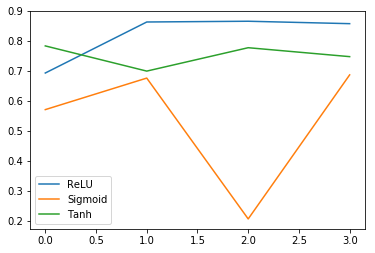

In [111]:
print("X-Axis = Hidden Layers")
print("Y-Axis = Accuracy")
plt.plot(hiddenlist,accuracyList,label="ReLU")
plt.plot(hiddenlist,accuracyListSig,label="Sigmoid")
plt.plot(hiddenlist,accuracyListTan,label = "Tanh")
#plt.xlabel("No. of hidden Layers 64 each")
#plt.ylabel("Accuracy")
#plt.title("Layer vs Accuracy")
plt.legend()
plt.show()

X-Axis = Hidden Layers
Y-Axis = Prediction Loss


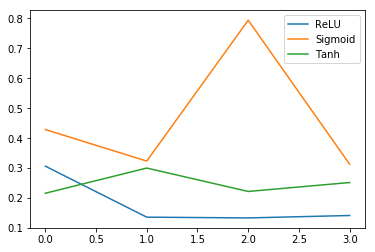

In [112]:
print("X-Axis = Hidden Layers")
print("Y-Axis = Prediction Loss")
plt.plot(hiddenlist,1-np.array(accuracyList),label="ReLU")
plt.plot(hiddenlist,1-np.array(accuracyListSig),label="Sigmoid")
plt.plot(hiddenlist,1-np.array(accuracyListTan),label = "Tanh")
#plt.xlabel("No. of hidden Layers-64 each")
#plt.ylabel("Accuracy")
#plt.title("Layer vs Prediction Loss")
plt.legend()
plt.show()

## Test File Prediction

In [36]:
'''
params :- 
NN(Neurons_in_each_layer,activation_in_all_layers,final_activation)
model.fit(data,mini_batch_size,epoch)
'''
originaldata = pd.read_csv('./Apparel/apparel-trainval.csv')

traindata = np.array(originaldata)[:48000,:]
testdata = np.array(originaldata)[48000:,:]
neuralnets = NN([784,64,64,10],'relu','relu')
neuralnets.fit(traindata,100,100)
accuracy = neuralnets.predict(testdata)
print("Validation accuracy: ",accuracy)

Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Validation accuracy:  0.8705833333333334


In [37]:
testdata = pd.read_csv('./Apparel/apparel-test.csv')
testdata = np.array(testdata)
neuralnets.predict_test(testdata)

# Question - 2

1. In the give dataset the task is to predict sale price of a house which is obviously a linear regression problem. Thus we can modify our neural network, which currently works like a logistic regression (using Cross Entropy as Loss). 

2. We can modify the above network to have a squared distance error of our predicted target variable and the ground truth target variable for all our samples in the dataset.We may have only one output neuron in the output layer. 

3. The delta of the final output layer will have the mean of squared distance. Since it's a Linear regresssion problem, one neuron is enough to predict the sale of the house.

4. Our choice of activation function may remain the same for the 3 hidden layers i.e ReLU since it is the most preferred one. But for a simple predicton task Sigmoid may be used as well depending on whether we have to deal with vanishing gradients or not. For simplicity we may use any linear activation (or ReLU) at the final layer.

5. Since the data in the dataset are not all in the same scale, we may have to do some preprocessing like standardization/normalization of data before training our model.

6. For categorical variables, we will have to encode it binarily, using one hot encoding (OHE). This new dataset (with extra columns because OHE) is now used for training our model.